In [6]:
import sys
sys.path.insert(0, '../../')  

import math
import numpy as np
import numpy.typing as npt
from numpy.linalg import matrix_rank
import matplotlib.pyplot as plt 
from gasp import train_gasp, run_gasp, simulate_ssfp, simulate_ssfp_simple, sampling, responses, SSFPParams

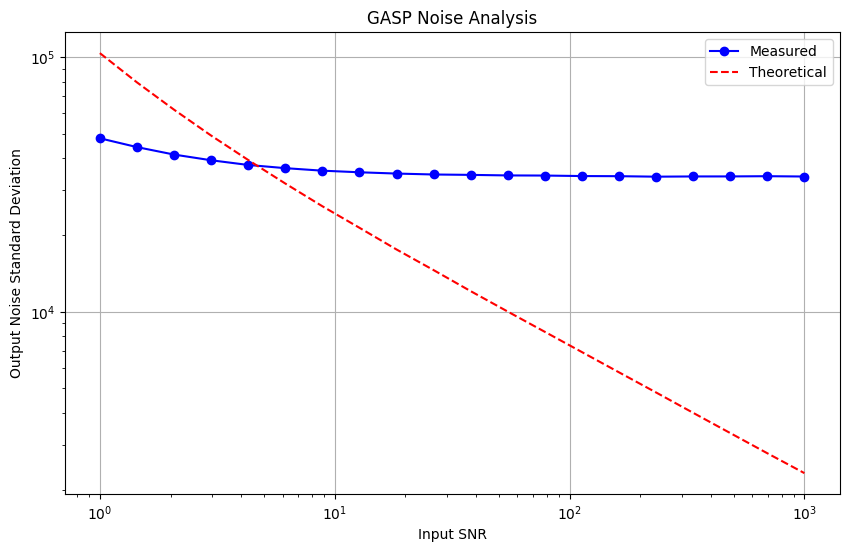

Noise Amplification Factor: 51803.2017


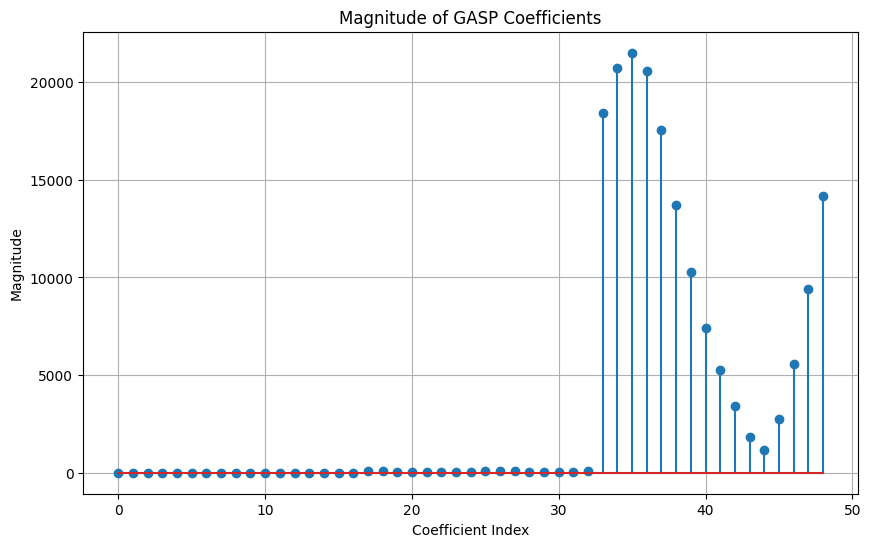

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List

def generate_GASP_coefficients(n=48):
    TRs = [5e-3, 10e-3, 20e-3]
    alpha = np.deg2rad(6)
    width = 256
    height = 1
    gradient = 2 * np.pi
    method = 'affine'
    T2base = 0.01
    T1T2ratio = 5.0

    D = responses.bandpass(width, bw=0.1, shift=-0.2, type='butterworth')
    TRs, PCs = sampling.grid_TR_sampling(n_points=n, TRs=TRs)
    params = SSFPParams(n, alpha, TRs, PCs)
    M = simulate_ssfp_simple(width=width, height=height, T1=T1T2ratio * T2base, T2=T2base, 
                                        params=params, minTR=np.min(params.TRs), gradient=gradient)
    _, A = train_gasp(M, D, method=method)
    return A

def generate_signal(shape: Tuple[int, int, int], snr: float = 10.0) -> np.ndarray:
    """Generate a simulated signal with noise."""
    true_signal = np.random.randn(*shape) + 1j * np.random.randn(*shape)
    noise_power = np.mean(np.abs(true_signal)**2) / snr
    noise = np.sqrt(noise_power/2) * (np.random.randn(*shape) + 1j * np.random.randn(*shape))
    return true_signal + noise

def apply_gasp(signal: np.ndarray, coeffs: np.ndarray) -> np.ndarray:
    """Apply GASP method to the input signal."""
    return np.sum(signal * coeffs[np.newaxis, np.newaxis, :], axis=2)

def calculate_theoretical_noise(input_noise: float, coeffs: np.ndarray) -> float:
    """Calculate theoretical output noise standard deviation."""
    return input_noise * np.sqrt(np.sum(np.abs(coeffs)**2))

def monte_carlo_simulation(shape: Tuple[int, int, int], coeffs: np.ndarray, 
                           snr: float, num_trials: int) -> Tuple[float, float]:
    """Perform Monte Carlo simulation and return measured vs theoretical noise."""
    output_noise_levels = []
    
    for _ in range(num_trials):
        signal = generate_signal(shape, snr)
        output = run_gasp(signal, coeffs)
        #output = apply_gasp(signal, coeffs)
        output_noise_levels.append(np.std(np.abs(output)))
    
    measured_noise = np.mean(output_noise_levels)
    input_noise = np.sqrt(np.mean(np.abs(signal)**2) / snr)
    theoretical_noise = calculate_theoretical_noise(input_noise, coeffs)
    
    return measured_noise, theoretical_noise

def plot_noise_analysis(snr_range: List[float], shape: Tuple[int, int, int], 
                        coeffs: np.ndarray, num_trials: int) -> None:
    """Plot measured vs theoretical noise for different SNR levels."""
    measured_noise_levels = []
    theoretical_noise_levels = []
    
    for snr in snr_range:
        measured, theoretical = monte_carlo_simulation(shape, coeffs, snr, num_trials)
        measured_noise_levels.append(measured)
        theoretical_noise_levels.append(theoretical)
    
    plt.figure(figsize=(10, 6))
    plt.plot(snr_range, measured_noise_levels, 'bo-', label='Measured')
    plt.plot(snr_range, theoretical_noise_levels, 'r--', label='Theoretical')
    plt.xlabel('Input SNR')
    plt.ylabel('Output Noise Standard Deviation')
    plt.title('GASP Noise Analysis')
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    plt.show()

# Example usage
if __name__ == "__main__":
    # Generate GASP coefficients
    coeffs = generate_GASP_coefficients(n=48)
    
    # Set up parameters
    shape = (64, 64, 48)  # (height, width, num_phase_cycles)
    snr_range = np.logspace(0, 3, 20)
    num_trials = 100

    # Run noise analysis and plot results
    plot_noise_analysis(snr_range, shape, coeffs, num_trials)

    # Calculate and print noise amplification factor
    noise_amp_factor = np.sqrt(np.sum(np.abs(coeffs)**2))
    print(f"Noise Amplification Factor: {noise_amp_factor:.4f}")

    # Plot GASP coefficients
    plt.figure(figsize=(10, 6))
    plt.stem(np.arange(len(coeffs)), np.abs(coeffs))
    plt.title('Magnitude of GASP Coefficients')
    plt.xlabel('Coefficient Index')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.show()